In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

indicadores = pd.read_excel("data/indicadores_CEINS.xls")
indicadores = indicadores[['fecha','occ']]

In [127]:
def regresa_ds(data,window=1,dropnan=True):
    for x in range(1,window+1):
        column = 't-'+str(window-x)
        data[column]=data['occ'].shift(window-x)
        
    if dropnan:
        data.dropna(inplace=True)
        
    data=data.drop('occ',1)
    
    return data



In [128]:
lags = 400
indicadores = regresa_ds(indicadores,lags,1)

In [129]:
import datetime
indicadores['fecha']=pd.to_datetime(indicadores['fecha'],format='%Y-%m-%d')
indicadores['dow']=indicadores['fecha'].dt.strftime('%A')
indicadores['year']=indicadores['fecha'].dt.strftime('%Y')
indicadores['month']=indicadores['fecha'].dt.strftime('%m')
indicadores['day']=indicadores['fecha'].dt.strftime('%d')
indicadores['y']=indicadores['t-0']
df_dow = pd.get_dummies(indicadores['dow'])
indicadores = pd.concat([indicadores,df_dow],axis=1)
indicadores=indicadores.drop('dow',1)
indicadores=indicadores.drop('t-0',1)



In [130]:
### Creamos data set de entrenamiento y prueba
train_size = int(len(indicadores)*0.66)
train, test = indicadores[0:train_size], indicadores[train_size:len(indicadores)]


In [131]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
         plt.subplot(models_to_plot[alpha])
         plt.tight_layout()
         plt.plot(data['fecha'],y_pred)
         plt.plot(data['fecha'],data['y'],'.')
         plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret, y_pred

/Users/ocamarena/.pyenv/versions/3.5.2/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.169858553210818e-18 / 1.1102230246251565e-16
  RuntimeWarning)


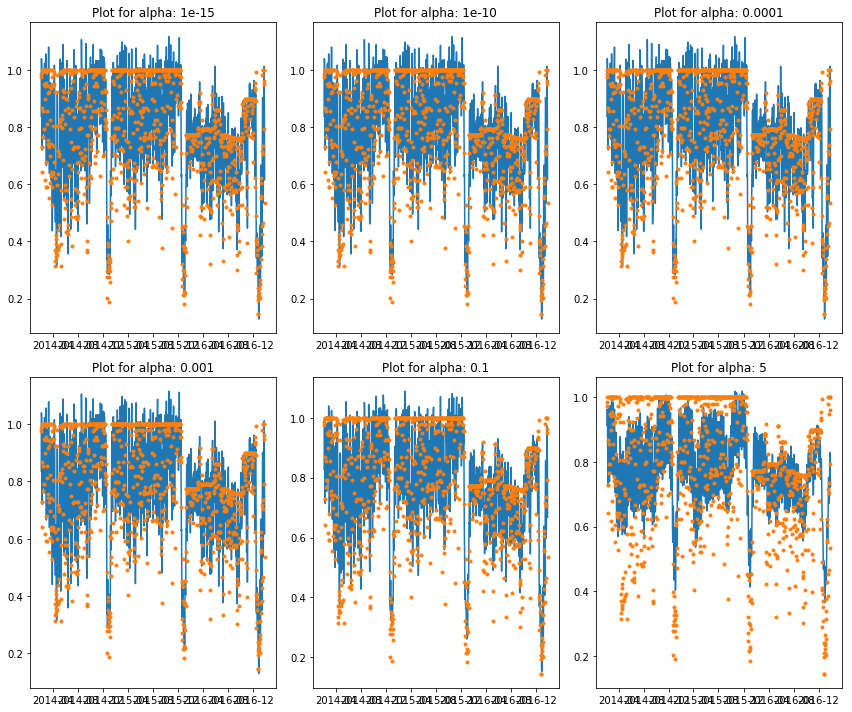

In [132]:
predictors=['t-1']
predictors.extend(['t-%d'%i for i in range(2,lags)])
predictors = predictors + ['year','month','day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, .1, 5, 10, 20]

col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,len(predictors)+1)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)
y_pred = [None] * 10
models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, .1:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,],y_pred[i] = ridge_regression(train, predictors, alpha_ridge[i], models_to_plot)

In [133]:
print(coef_matrix_ridge)

                  rss intercept   coef_x_1   coef_x_2   coef_x_3   coef_x_4  \
alpha_1e-15   7.23688   10.7022   0.708405  -0.106384   0.067584  0.0596453   
alpha_1e-10   7.23688   10.5851   0.708405  -0.106384   0.067584  0.0596453   
alpha_1e-08   7.23688   10.5851   0.708405  -0.106384   0.067584  0.0596453   
alpha_0.0001   7.2369   10.5927   0.707671  -0.105704  0.0672986  0.0597841   
alpha_0.001   7.23812   10.6592   0.701244 -0.0998248  0.0648946  0.0609221   
alpha_0.01    7.30575   11.2262   0.649674 -0.0569704  0.0504784  0.0664101   
alpha_0.1      8.3252   13.8274   0.445861   0.052816  0.0382653  0.0627627   
alpha_5       18.2472   7.86132  0.0670934  0.0391414  0.0267652  0.0244537   
alpha_10      21.6998   5.68885  0.0421661  0.0264216  0.0186722  0.0171368   
alpha_20      25.9621   3.93664  0.0255467  0.0165942  0.0117896  0.0108927   

               coef_x_5   coef_x_6   coef_x_7   coef_x_8     ...      \
alpha_1e-15    0.039251 -0.0223108  0.0212943  0.0493051  

In [134]:
##Escogemos el modelo con alpha igual 1e-15 lo entrenamos nuevamente y lo probamos
alpha = 1e-15
predictors=['t-1']
predictors.extend(['t-%d'%i for i in range(2,lags)])
predictors = predictors + ['year','month','day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ridgereg = Ridge(alpha=alpha,normalize=True)
ridgereg.fit(train[predictors],train['y'])
y_pred_test = ridgereg.predict(test[predictors])



/Users/ocamarena/.pyenv/versions/3.5.2/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.169858553210818e-18 / 1.1102230246251565e-16
  RuntimeWarning)


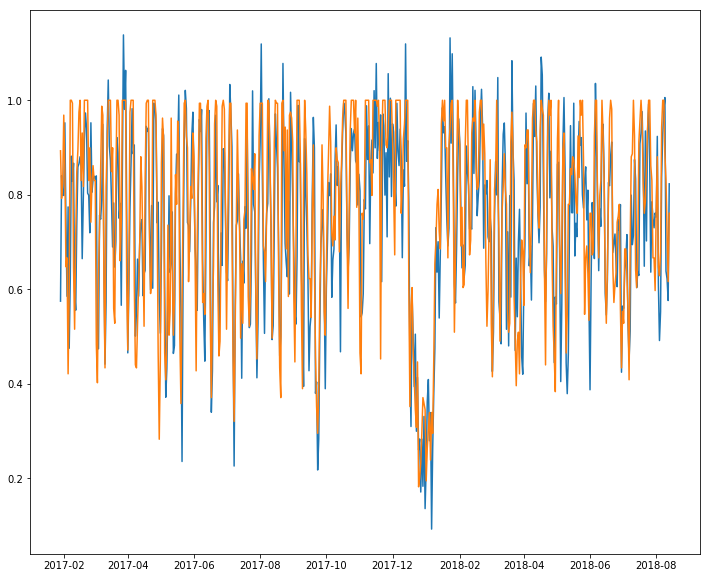

In [135]:
plt.plot(test['fecha'],y_pred_test)
plt.plot(test['fecha'],test['y'])
plt.show()

In [139]:
### Pronostico a una ventana de 7 días futuros
import datetime
from datetime import timedelta  
pronostico_raw = pd.read_csv("data/Pronostico_CEINS.csv")
pronostico_raw = pronostico_raw[['fecha','occ']]
pronostico_raw['fecha']=pd.to_datetime(pronostico_raw['fecha'],format='%Y-%m-%d')

fecha_pron =  datetime.date(2018, 8,14)
fecha_inicio = fecha_pron

predictors=['t-1']
predictors.extend(['t-%d'%i for i in range(2,lags)])
predictors = predictors + ['year','month','day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

window=40
i=0


while i < window:
    pronostico = pronostico_raw.copy()
    pronostico = regresa_ds(pronostico,lags,1)
    pronostico['fecha']=pd.to_datetime(pronostico['fecha'],format='%Y-%m-%d')
    pronostico['dow']=pronostico['fecha'].dt.strftime('%A')
    pronostico['year']=pronostico['fecha'].dt.strftime('%Y')
    pronostico['month']=pronostico['fecha'].dt.strftime('%m')
    pronostico['day']=pronostico['fecha'].dt.strftime('%d')
    pronostico['y']=pronostico['t-0']
    df_dow = pd.get_dummies(pronostico['dow'])
    pronostico = pd.concat([pronostico,df_dow],axis=1)
    pronostico=pronostico.drop('dow',1)
    pronostico=pronostico.drop('t-0',1)
    pronostico = pronostico[(pronostico.fecha >=fecha_pron)]
    aux=pronostico.loc[pronostico['fecha'] == fecha_pron]
    aux=aux[predictors]
    y_pred_test = ridgereg.predict(aux)
    pronostico_raw.loc[pronostico_raw['fecha'] == fecha_pron,'occ']=y_pred_test
    fecha_pron=fecha_pron+timedelta(days=1)
    i = i+1
    

fecha_fin = fecha_pron-timedelta(days=1)


pronostico_raw = pronostico_raw[(pronostico_raw.fecha >=fecha_inicio)&(pronostico_raw.fecha <=fecha_fin)]     
pronostico_raw['Hab_Ocup']=round(pronostico_raw['occ']*159)
pronostico_raw.to_csv('data/pronostico.csv', sep=',')

    

    